# PyEO Machine Learning: How to train your machine learning model.

This notebook was developed for pyeo on a Windows computer.

In this notebook, we will create a machine learning model to classify land cover from a satellite image. This is a step that is needed to proceed to a post-classification change detection between different image acquisiton dates.
To train a model, we will need training data. For PyEO, we define training data as pixel-based land surface reflectance values at multiple wavelengths (image bands) and their corresponding 'true' land cover classes from our own visual image interpretation.
The next section below details how to generate this training data by manually delineating polygons using the QGIS software.

# Delineate Sample Areas using QGIS

## Live Demo: Training Sample Delineation

- Prof. Heiko Balzter will show a recorded demo of how to delineate training data in QGIS.

In [1]:
from IPython.display import HTML
#HTML('<iframe width="1080" height="490" src="https://leicester.cloud.panopto.eu/Panopto/Pages/Viewer.aspx?id=a4568baf-c85d-4fab-b6c4-ac9300ed6ab2" frameborder="0" allowfullscreen></iframe>')

## QGIS Training Data Specification Process Guide
- In the left hand panel of JupyterLab, navigate to `pyeo/models` within your installation directory and right click to download the sample image to your laptop
  - You need the file `composite_T36MYE_20230220T074941_clipped.tif`
- Once downloaded, open the image in QGIS on your laptop
- Add a shapefile layer
- Toggle editing of the shapefile layer
- Add a field which should be integer and named `class`
- Delineate features using the **Add Polygon Feature** tool. It looks like this: ![image](./Create_polygon.PNG) 
- Add training polygons for classes of interest to your shape file. 
- So that we can compare results please train for the following land use classes, using the integer CODE assigned to each in the table below:
  - `Primary Forest` 1; 
  - `Plantation Forest` 2;
  - `Bare Soil` 3;
  - `Crops` 4;
  - `Grassland` 5;
  - `Artificial` 13;
- Save your shapefile to your laptop hard drive
- Use the 'Upload' button to bring your saved shapefile to the folder 'model_dir' within your PyEO installation on SEPAL


## QGIS Tips

- Whilst in QGIS, make sure you have the **Digitizing** and **Advanced Digitizing** toolbars enabled. To do so, click:  
    - View > Toolbars > Tick Digitizing and Advanced Digitizing
- Avoid delineating near the edges of land cover, e.g. at the forest edge adjacent to a road. These edge pixels will capture the variation in land-cover at the sub-pixel level, confusing your classifier. 
- The **Reshape Features** tool, is extremely useful for extending already delineated polygons. Click inside the polygon you want to extend, then click any points outside of the polygon (covering your land cover class of interest), once ready - click inside the polygon to complete the loop, and right click to finish delineation. The tool icon looks like this: ![image](./Reshape_features.PNG)
- Install Google Earth Pro on your PC, https://www.google.com/earth/about/versions/ , which offers very-high resolution satellite imagery, and Google StreetView, to help you understand the land covers you are delineating.
- Install the QGIS plugin, **Send2GE**. This plugin sends your location directly to your installed Google Earth Pro. To do so, click on the Send2GE icon, ![image](./Send2GE.PNG), and then click on the location you want to view in Google Earth Pro.
- When developing models in future you may wish to develop your own choice of Land Cover classes and tailor them to what you want your model to achieve. Listed below is the full list of classes that we have evaluated for our `PyEO` forest alert classifier, but alternative classes may be more appropriate for your needs.

    1. Primary Forest
    2. Plantation Forest
    3. Bare Soil
    4. Crops
    5. Grassland
    6. Open Water
    7. Burn Scar
    8. Cloud
    9. Cloud Shadow
    10. Haze
    11. Sparse Woodland
    12. Dense Woodland
    13. Artificial
    

# Setup: Requirements to use this Notebook

## Check the working directory is set to `pyeo` within your PyEO installation

In [2]:
pwd

'Z:\\gy7709\\pyeo\\notebooks'

In [3]:
cd Z:\gy7709\pyeo

Z:\gy7709\pyeo


In [4]:
pwd

'Z:\\gy7709\\pyeo'

## Import the Required Libraries

Before proceeding, let's check that the import statements from pyeo execute correctly. You may get a Windows or IOS warning about patching of GetVirtualMemArray. Let's ignore that for now.

In [24]:
import os
from pathlib import Path
from pyeo import classification as cls
from pyeo import filesystem_utilities as file_utils
import pandas as pd
import platform

from matplotlib.colors import LinearSegmentedColormap
from osgeo import gdal
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import ensemble as ens
import numpy as np
import joblib

print("Library imports complete")

Library imports complete


## Specify the Model Storage Directory

In [6]:
pyeo_dir = "Z:\gy7709\pyeo"

In [7]:
os.chdir(pyeo_dir)

In [8]:
pwd

'Z:\\gy7709\\pyeo'

In [9]:
model_dir = os.path.join(pyeo_dir, "models", "my_model")
log_dir = os.path.join(pyeo_dir, "log")

# Create the folder if it doesn't yet exist
os.chdir(pyeo_dir)
if not os.path.exists(model_dir): 
    os.mkdir(model_dir)
if not os.path.exists(log_dir): 
    os.mkdir(log_dir)


- TIP: Use the File Browser to check your new folder now exists

## Initialise Logging Output

- When running `PyEO`, we record our processing steps, chosen parameters and other information in a log file (with file ending `.log`).
- If we are ever curious about what `PyEO` has done and when, we can look at the log file.
- Below, we initialise our log file 
- **Note: the .log does not need to exist before running the function**

In [10]:
log_filename = "model_log.log"
log = file_utils.init_log(os.path.join(log_dir, log_filename))

# fix any forward slashes in directory paths in the ini file if running on Windows
#if platform.system() == "Windows":
#    model_dir = model_dir.replace("/","\\")
#    log_dir = log_dir.replace("/","\\")
    
# Let's add some information to the log
log.info(f'pyeo_Model_Training Notebook Started:')
log.info(f'- pyeo_dir set to: {pyeo_dir}')
log.info(f'- model_dir set to: {model_dir}')
log.info(f'- log_dir set to: {log_dir}')    

2024-08-16 10:08:52,614: INFO: ---------------------------------------------------------------
2024-08-16 10:08:52,627: INFO: ---                 PROCESSING START                        ---
2024-08-16 10:08:52,630: INFO: ---------------------------------------------------------------
2024-08-16 10:08:52,630: INFO: pyeo_Model_Training Notebook Started:
2024-08-16 10:08:52,632: INFO: - pyeo_dir set to: Z:\gy7709\pyeo
2024-08-16 10:08:52,634: INFO: - model_dir set to: Z:\gy7709\pyeo\models\my_model
2024-08-16 10:08:52,638: INFO: - log_dir set to: Z:\gy7709\pyeo\log


# Model Training and Classification, Step by Step

- In this section, we will follow the individual steps to extract spectral information from the Sentinel-2 imagery using our training shapefiles, train a Random Forest model on the spectral reflectance values of the land cover classes, and classify a Sentinel-2 image tile.

## Extract Spectral Information from Sentinel-2 Imagery

- Since we have delineated our training polygons, we can now extract the spectral information from the imagery, by running `cls.extract_features_to_csv()` in the cell below.  
- First, specify the paths to the training shapefile, training raster and the out directory.

In [11]:
# specify the path of the training shapefile
training_shape_filename = "composite_T36MYE_20230220T074941_clipped_features.shp"
# specify the path of the training raster
training_raster_filename = "composite_T36MYE_20230220T074941_clipped.tif"
# specify the output folder
out_dir = model_dir
# specify the output filename for the model
model_name = "my_model"
model_out_filename = f"{model_name}.pkl"
# specify the output filename for the csv
feature_out_filename = f'{model_name}_features.csv'

log.info(f'File and Folder Specification Started::')
log.info(f'- training_shape_filename set to: {training_shape_filename}')
log.info(f'- training_raster_filename set to: {training_raster_filename}')
log.info(f'- out_dir set to: {out_dir}')
log.info(f'- model_out_filename set to: {model_out_filename}')
log.info(f'- feature_out_filename set to: {feature_out_filename}')


2024-08-16 10:08:58,661: INFO: File and Folder Specification Started::
2024-08-16 10:08:58,663: INFO: - training_shape_filename set to: composite_T36MYE_20230220T074941_clipped_features.shp
2024-08-16 10:08:58,666: INFO: - training_raster_filename set to: composite_T36MYE_20230220T074941_clipped.tif
2024-08-16 10:08:58,669: INFO: - out_dir set to: Z:\gy7709\pyeo\models\my_model
2024-08-16 10:08:58,672: INFO: - model_out_filename set to: my_model.pkl
2024-08-16 10:08:58,674: INFO: - feature_out_filename set to: my_model_features.csv


### Create `out_folder` if it does not exist

In [12]:
if not os.path.exists(os.path.join(pyeo_dir, out_dir)):
    os.mkdir(os.path.join(pyeo_dir, out_dir))

### Run `extract_features_to_csv`

Now, we can run the `cls.extract_features_to_csv` function to create a csv file with the spectral signatures for each land cover class. If the column heading of your training shapefile is not `CODE`, substitute the correct column name with the `attribute` argument.

In [13]:
# declare our path variables as easier to read variables
out_path = os.path.join(out_dir, feature_out_filename)
training_raster_path = os.path.join(model_dir, training_raster_filename)
training_shapefile_path = os.path.join(model_dir, training_shape_filename)

log.info(f'Feature Extraction Started:')
log.info(f'- out_path set to: {out_path}')
log.info(f'- training_raster_path set to: {training_raster_path}')
log.info(f'- training_shapefile_path set to: {training_shapefile_path}')

2024-08-16 10:09:02,713: INFO: Feature Extraction Started:
2024-08-16 10:09:02,715: INFO: - out_path set to: Z:\gy7709\pyeo\models\my_model\my_model_features.csv
2024-08-16 10:09:02,717: INFO: - training_raster_path set to: Z:\gy7709\pyeo\models\my_model\composite_T36MYE_20230220T074941_clipped.tif
2024-08-16 10:09:02,720: INFO: - training_shapefile_path set to: Z:\gy7709\pyeo\models\my_model\composite_T36MYE_20230220T074941_clipped_features.shp


In [14]:
# run the function to extract the spectral values and assigned classes from the training raster and training shapefile
cls.extract_features_to_csv(in_ras_path=training_raster_path,
                            training_shape_path=training_shapefile_path,
                            out_path=out_path,
                            attribute="class")

2024-08-16 10:09:04,424: INFO: Get training data from Z:\gy7709\pyeo\models\my_model\composite_T36MYE_20230220T074941_clipped.tif
2024-08-16 10:09:04,426: INFO:                    and Z:\gy7709\pyeo\models\my_model\composite_T36MYE_20230220T074941_clipped_features.shp
2024-08-16 10:09:04,855: INFO: Shape raster path Z:\gy7709\pyeo\tmpg4zcc4qb\composite_T36MYE_20230220T074941_clipped_features_rasterised


0 No IOError with file Z:\gy7709\pyeo\tmps7gbog74\composite_T36MYE_20230220T074941_clipped_features_rasterised
0 No IOError with file Z:\gy7709\pyeo\tmpg4zcc4qb\composite_T36MYE_20230220T074941_clipped_features_rasterised


2024-08-16 10:09:05,710: INFO: 4 bands in image file
2024-08-16 10:09:05,710: INFO: 11943 training pixels in shapefile


- Let's see what `features.csv` looks like, by reading in the csv and printing the first 5 rows.  
- Each row represents a pixel of a certain class. The first column in each row is the class of that pixel, with the columns after that being the Sentinel 2 blue, green, red and NIR value of that pixel.

In [15]:
# declare out_path from previous cell as csv_path, to avoid confusion
csv_path = out_path

# read in our spectral signatures
features = pd.read_csv(csv_path)

features.columns = ["class", "R", "G", "B", "nIR"]

# prints the first 5 rows of features
features.head(5)

,class,R,G,B,nIR
0,2.0,189.0,306.0,206.0,2906.0
1,2.0,190.0,295.0,204.0,2850.0
2,2.0,187.0,289.0,202.0,2773.0
3,2.0,170.0,297.0,202.0,2798.0
4,2.0,191.0,308.0,209.0,2873.0


In [16]:
features.tail(5)

,class,R,G,B,nIR
11937,5.0,365.0,618.0,487.0,3080.0
11938,5.0,353.0,614.0,478.0,2927.0
11939,5.0,341.0,595.0,472.0,2938.0
11940,5.0,348.0,615.0,473.0,3074.0
11941,5.0,359.0,583.0,471.0,3056.0


- Note: your model folder should now contain a .csv file of features - check using the file explorer on the left

## Model Creation and Training

- Now we can create a scikit-learn Extra Trees Classifier using PyEO:

In [17]:
log.info(f'Model Building Started:')

# initialise an Extra Trees Classifier
model = ens.ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.55, min_samples_leaf=2,
                                    min_samples_split=16, n_estimators=100, n_jobs=-1, class_weight='balanced')

# load signatures from csv file
features, labels = cls.load_signatures(csv_path, sig_datatype=np.int32)
print(features)
print(labels)

# split into test and train samples, reserving 25% for testing model accuracy
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.25, random_state=101)

# train the model
model.fit(X_train, y_train)

# save the model
model_path = os.path.join(out_dir, model_out_filename)
joblib.dump(model, filename = model_path)

log.info(f"Model saved at {model_path}")

2024-08-16 10:09:10,823: INFO: Model Building Started:


[[ 182  316  195 2780]
 [ 189  306  206 2906]
 [ 190  295  204 2850]
 ...
 [ 341  595  472 2938]
 [ 348  615  473 3074]
 [ 359  583  471 3056]]
[2 2 2 ... 5 5 5]


2024-08-16 10:09:11,620: INFO: Model saved at Z:\gy7709\pyeo\models\my_model\my_model.pkl


- Note: your model folder should now contain a .pkl file containing your model - check using the file explorer on the left

## Accuracy Statistics

- Now that we have a model trained from shapefiles defined over Sentinel-2 image tile, we should assess the model accuracy.  
- To do that, we will use the model to predict the classes of `y_test` from the values of `X_test`, which comprise the 25% that we reserved for testing model accuracy.

In [18]:
log.info(f'Model Performance Analysis Started:')

confusion_matrix_out_filename = f'{model_name}_confusion_matrix.txt'
class_scores_out_filename = f'{model_name}_class_scores.txt'

# make a prediction
y_pred = model.predict(X_test)

# create a confusion matrix
matrix = confusion_matrix(y_true=y_test, y_pred=y_pred,)

# write the confusion matrix to file
with open(os.path.join(out_dir, confusion_matrix_out_filename), "w") as txt:
    print(matrix, file=txt)

# write classification labels
target_names = ["Primary Forest",
          "Plantation Forest",
          "Bare Soil",
          "Crops",
          "Grassland",
          "Artificial"]

# view the matrix
print(matrix)

2024-08-16 10:09:13,702: INFO: Model Performance Analysis Started:


[[1478   38    0    0    0    0]
 [   8  337    0    0    0    0]
 [   0    0  152    0    0    0]
 [   0    0    0  344    0    0]
 [   0    0    0    0  458    0]
 [   0    0    1    0    0  170]]


In [19]:
# create classification metrics report
report = classification_report(y_true=y_test, y_pred=y_pred, digits=6, target_names=target_names)

# write classification report to file
with open(os.path.join(out_dir, class_scores_out_filename), "w") as txt:
    print(report, file=txt)

# view the report
print(report)

                   precision    recall  f1-score   support

   Primary Forest   0.994616  0.974934  0.984677      1516
Plantation Forest   0.898667  0.976812  0.936111       345
        Bare Soil   0.993464  1.000000  0.996721       152
            Crops   1.000000  1.000000  1.000000       344
        Grassland   1.000000  1.000000  1.000000       458
       Artificial   1.000000  0.994152  0.997067       171

         accuracy                       0.984260      2986
        macro avg   0.981125  0.990983  0.985763      2986
     weighted avg   0.985226  0.984260  0.984504      2986



In a classification, the precision for a class is the number of true positives (i.e. the number of pixels correctly labelled as belonging to the class) divided by the total number of pixels labelled as belonging to the class (i.e. the sum of true positives and false positives). 

Recall for a class is defined as the number of true positives (i.e. correctly classified pixels) divided by the total number of pixels that actually belong to the class (i.e. the sum of true positives and false negatives, which are pixels which were not labelled as belonging to the class but should have been). 

The F1 score is the harmonic mean of the precision and recall and indicates the overall accuracy of each class. 

Support is the number of pixels that belongs to each class in the training data.

(Modified after Wikipedia, 2024).

## Image Classification

- Once we are happy with the performance of the model we can now classify a Sentinel-2 image tiles so long as they have similar land use and vegetation cover (and thus spectral characteristics) to the imagery used to train the model.
- Here, we will simply use our training image and see how well the classification extends over the untrained areas of the image

In [20]:
pwd

'Z:\\gy7709\\pyeo'

- Note: your model folder should now contain a classified image with '_full_class' appended to the raw image name - check using the File Explorer.

In [21]:
log.info(f'Image Classification with Model Started:')

from pyeo import classification as cls

# test_raster_path = training_raster_path
test_raster_filename = 'composite_T36MYE_20230220T074941_clipped.tif'
test_raster_path = os.path.join(model_dir, test_raster_filename)

if not os.path.exists(test_raster_path):
    log.error(f"File {test_raster_path} does not exist.")

if not os.path.exists(model_path):
    log.error(f"File {model_path} does not exist.")

class_out_filename = f'{os.path.splitext(test_raster_filename)[0]}_full_class.tif'
class_out_path = os.path.join(out_dir, class_out_filename)

cls.classify_image(image_path=test_raster_path,
                   model_path=model_path,
                   class_out_path=class_out_path,
                   prob_out_path=None,
                   apply_mask=False,
                   out_format="GTiff",
                   chunks=10,
                   nodata=0,
                   skip_existing = False)

log.info(f'Classification Image Saved: {class_out_path}')


2024-08-16 10:09:20,569: INFO: Image Classification with Model Started:
2024-08-16 10:09:20,584: INFO: Classifying file: Z:\gy7709\pyeo\models\my_model\composite_T36MYE_20230220T074941_clipped.tif
2024-08-16 10:09:20,586: INFO: Saved model     : Z:\gy7709\pyeo\models\my_model\my_model.pkl
2024-08-16 10:09:21,244: INFO: Proportion of non-missing pixel values: 100.0%
2024-08-16 10:09:21,321: INFO:    Number of chunks 10
2024-08-16 10:09:21,325: INFO:    Chunk size 265194
2024-08-16 10:09:21,328: INFO:    Chunk residual 6
2024-08-16 10:09:21,332: INFO:    Classifying chunk 1 of size 265194
2024-08-16 10:09:22,991: INFO:    Classifying chunk 2 of size 265194
2024-08-16 10:09:25,206: INFO:    Classifying chunk 3 of size 265194
2024-08-16 10:09:26,618: INFO:    Classifying chunk 4 of size 265194
2024-08-16 10:09:28,433: INFO:    Classifying chunk 5 of size 265194
2024-08-16 10:09:29,982: INFO:    Classifying chunk 6 of size 265194
2024-08-16 10:09:31,300: INFO:    Classifying chunk 7 of size

0 No IOError with file Z:\gy7709\pyeo\tmprli_wmlu\composite_T36MYE_20230220T074941_clipped_full_class.tif
0 No IOError with file Z:\gy7709\pyeo\models\my_model\composite_T36MYE_20230220T074941_clipped_full_class.tif
Z:\gy7709\pyeo\models\my_model\composite_T36MYE_20230220T074941_clipped_full_class.tif already exists. Deleting the old file.


2024-08-16 10:09:39,697: INFO: Created classification image file: Z:\gy7709\pyeo\models\my_model\composite_T36MYE_20230220T074941_clipped_full_class.tif
2024-08-16 10:09:39,733: INFO: Classification Image Saved: Z:\gy7709\pyeo\models\my_model\composite_T36MYE_20230220T074941_clipped_full_class.tif


## Visualise the Classification Imagery

Now we can now define a function to colormap and visualise the classification image

In [25]:
def visualise_classification(classified_path: str, labels: list):
    ds = gdal.Open(classified_path)
    array = np.array(ds.GetRasterBand(1).ReadAsArray())
    
    unique, _counts = np.unique(array, return_counts=True)

    counts=list(np.zeros(max(unique)+1,'int'))
    for i in range(0, len(_counts)):
        counts[unique[i]] = _counts[i]

    #counts, _ = np.histogram(array, bins = len(labels))
    print(counts)
    
    percent = counts / sum(counts)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))


    def discrete_cmap(N, base_cmap=None):
        """Create an N-bin discrete colormap from the specified input map"""

        # this function was taken on 10/03/2023 from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
        # author: Jake Vanderplas
        
        # warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
        base = plt.cm.get_cmap(base_cmap)
        color_list = base(np.linspace(0, 1, N))
        cmap_name = base.name + str(N)
        return base.from_list(cmap_name, color_list, N)

    cmap = discrete_cmap(len(labels), base_cmap="coolwarm")
    # cmap = discrete_cmap(len(labels), base_cmap="cubehelix")
    # cmap.set_bad("red")
    colour_list = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]
    print(cmap.N)
    if cmap.N <=14:
        log.info("Defining custom colour table for up to 13 classes and a missing data class of 0 (0..13)")
        colour_list = [
                      [0, 0, 0, 1],  # no data
                      [0, 100/255, 0, 1],  # Primary Forest
                      [154/255, 205/255, 50/255, 1],  # plantation Forest
                      [139/255, 69/255, 19/255, 1],  # Bare Soil
                      [189/255, 183/255, 107/255, 1],  # Crops
                      [240/255, 230/255, 140/255, 1],  # Grassland
                      [0, 0, 205/255, 1],  # Open Water
                      [128/255, 0, 0, 1],  # Burn Scar
                      [255/255, 255/255, 255/255, 1],  # cloud
                      [60/255, 60/255, 60/255, 1],  # cloud shadow
                      [128/255, 128/255, 128/255, 1],  # Haze
                      [46/255, 139/255, 87/255, 1],  # Open Woodland
                      [92/255, 145/255, 92/255, 1],  # Closed Woodland
                      [255/255, 30/255, 30/255, 1]  # Artificial
                      ]
        cmap = LinearSegmentedColormap.from_list("pyeo_class_colors", colour_list, N=cmap.N)
    
    x = np.arange(0, len(labels))
    ax1.bar(x, percent, color=colour_list)
    ax1.set_title("Classes distribution")
    ax2.set_title("Classification raster displayed")
    im = ax2.imshow(array, cmap=cmap, aspect="auto", vmin=-0.5, vmax=len(labels)+0.5)
    fig.colorbar(im, ax=ax2) 
    plt.show()

    return

C:\Users\hb91\AppData\Local\Temp\ipykernel_23668\525787428.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)
2024-08-16 10:11:40,170: INFO: Defining custom colour table for up to 13 classes and a missing data class of 0 (0..13)


Unique class values:
[ 1  2  3  4  5 13]
6
[0, 1414007, 117665, 39798, 303407, 663582, 0, 0, 0, 0, 0, 0, 0, 113487]
14


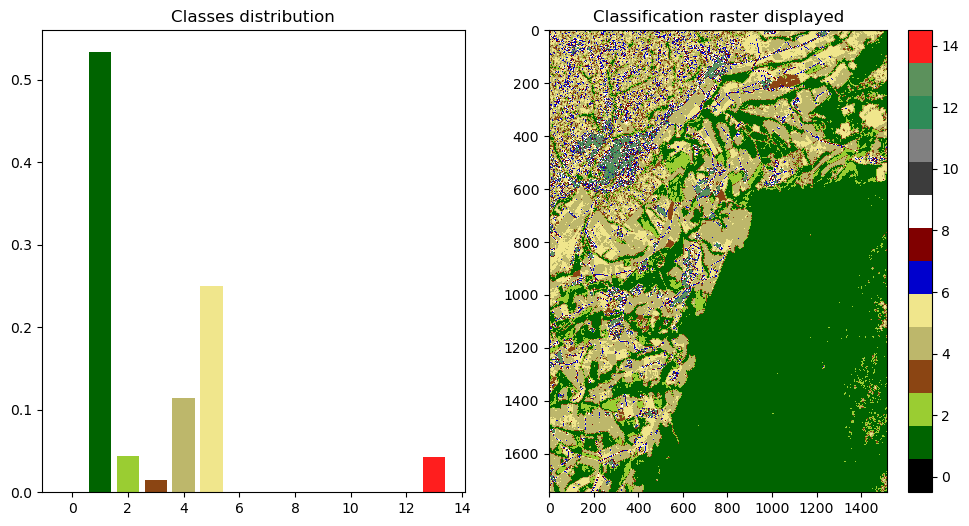

In [26]:
# create a list of class labels

# load the class labels from the csv file
features, class_values = cls.load_signatures(csv_path, sig_datatype=np.int32)
class_values = np.unique(class_values)

print("Unique class values:")
print(class_values)
print(len(class_values))
labels = ["no data",
          "Primary Forest",
          "Plantation Forest",
          "Bare Soil",
          "Crops",
          "Grassland",
          "Open Water",
          "Burn Scar",
          "Cloud",
          "Cloud shadow",
          "Haze",
          "Open Woodland",
          "Closed Woodland",
          "Artificial"
         ]

visualise_classification(classified_path=class_out_path, labels=labels)